In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mahip\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Build the dataset

block_size = 3  #Context length --> how many characters we take to perdict the next char
X,Y = [],[]      #X = the input set  Y = the label set
for w in words:
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]  #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

training split , dev/validation split, test split

train parameters , train hyperparameters, evaluate the performance of the model

80%, 10%, 10%

In [34]:
#build dataset

def build_dataset(words):
    block_size = 3
    X,Y=[],[]
    for w in words:
        
        context = [0]* block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[1:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182430, 3]) torch.Size([182430])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [35]:
Xtr.shape , Ytr.shape

(torch.Size([182430, 3]), torch.Size([182430]))

F.one_hot(torch.tensor(5),num_classes=27).float() @ C

C[5]

#concatinate the matrix to enable matrix multiplication
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape

torch.cat(torch.unbind(emb,1),1)

views are more efficient as it dones not create any new memory for the tensor storage
concat on the other hand creats a new tensor .. thus is less efficient

In [67]:
g = torch.Generator().manual_seed(2147483647)

#lookup table
C = torch.randn((27,10),generator=g)

#Weights and bias for layer 1  and Layer 2
W1 = torch.randn((30,200),generator=g)   #6 bcz we have 2 dimnsional encoding and we have 3 of them(in the reserch paper)
#100 is number of neurons in the second layer.. any number can be picked for now
b1 = torch.randn(200,generator=g)  #random bias
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)

parameters = [C, W1, b1, W2, b2]

In [68]:
sum(p.nelement() for p in parameters) # number of parameters in totol

11897

In [69]:
for p in parameters:
    p.requires_grad = True

In [70]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [71]:
lri = []
lossi = []
stepi=[]

In [79]:
for i in range(50000):
    
    #minibatch construct 
    ix = torch.randint(0,Xtr.shape[0],(32,))
    
    #Forward Pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0],30)  @  W1 + b1 )
    logits = h @ W2 + b2
#     counts = logits.exp()
#     probs = counts/counts.sum(1,keepdims=True)
#     loss = -probs[torch.arange(32),Y].log().mean()
    loss = F.cross_entropy(logits,Ytr[ix])
    

    #Backward PAss
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
#     lr = lrs[i]
    lr = 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
        
#     #track stats
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
        
print(loss.item())

2.411602020263672


In [80]:
emb = C[Xtr]
h = torch.tanh(emb.view(emb.shape[0],30)  @  W1 + b1 )
logits = h @ W2 + b2
#     counts = logits.exp()
#     probs = counts/counts.sum(1,keepdims=True)
#     loss = -probs[torch.arange(32),Y].log().mean()
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.1584, grad_fn=<NllLossBackward0>)

In [81]:
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0],30)  @  W1 + b1 )
logits = h @ W2 + b2
#     counts = logits.exp()
#     probs = counts/counts.sum(1,keepdims=True)
#     loss = -probs[torch.arange(32),Y].log().mean()
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1920, grad_fn=<NllLossBackward0>)

in general practice cross_entropy is used to calc the loss 
bcz :

numerical values can me much more well behaved 
and forward pass can be much mroe efficient(no new creation fo tensors)
bachward pass can be much more efficient(same as doint backward pass of tanh is easier than backward pass of (e^2x - 1)/(e^2x + 1))

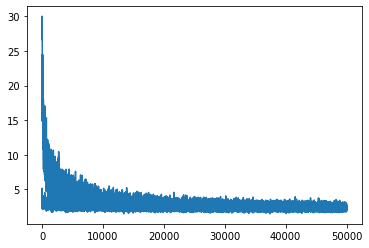

In [78]:
plt.plot(stepi,lossi)

In [ ]:
least loss is obtained around -0.1 lr

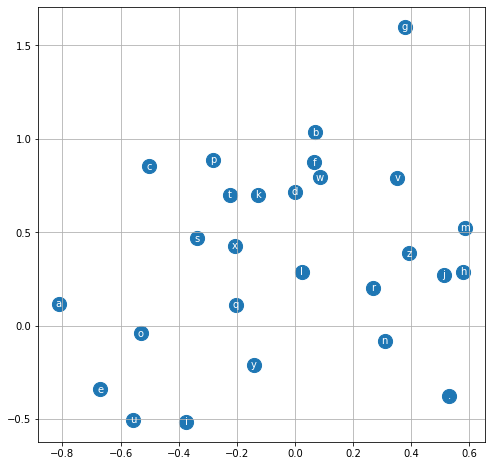

In [66]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va="center",color='white')
plt.grid('minor')

In [88]:
#sample from the model
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break
        
    print(''.join(itos[i] for i in out))

dex.
mariah.
makila.
kayderrinishana.
nylandr.
katha.
samiyah.
javer.
gotai.
moriellah.
jazireda.
kathana.
sadel.
tkaviyrion.
bstihilie.
brtallah.
kasdri.
antil.
pyawaisa.
jarridynn.
